<a href="https://colab.research.google.com/gist/22961-Deep-learning/52b44ccc7f3a705100831062f7395334/22961_7_3_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

train_data_transformed = torchvision.datasets.MNIST(
    root="/MNIST", train=True, download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(
    train_data_transformed, batch_size=256)
img, _ = next(iter(train_dataloader))

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cuda:0


#Transposed Conv

In [18]:
def conv_backward(dCdY,K):
  p,q   = K.size()
  Hy,Wy = dCdY.size()
  H     = Hy+p-1
  W     = Wy+q-1
  dCdX  = torch.zeros((H,W))
  for r in range(Hy):
   for s in range(Wy):
    #forward: Y[r,s]  = (X[r:r+p,s:s+q]*K).sum()
    #backward:
    dCdX[r:r+p,s:s+q] += dCdY[r,s]*K
  return dCdX

In [19]:
def transposed_conv(input,K):
  Cin,p,q   = K.size()
  _,Hy,Wy     = input.squeeze().size()
  H         = Hy+p-1
  W         = Wy+q-1
  output    = torch.zeros((H,W))
  for c in range(Cin):
    output += conv_backward(input.squeeze()[c,...],K[c,...])
  return output

In [20]:
A=nn.ConvTranspose2d(2,1,2,bias=False)
K=A.weight[:,0,...]
print(K.size())

torch.Size([2, 2, 2])


In [21]:
input=torch.randn((1,2,3,3))
with torch.no_grad():
  print(A(input).squeeze())
  print(transposed_conv(input,K))

tensor([[ 0.5027, -0.6244,  0.2393,  0.3727],
        [-0.3430, -0.1717, -0.3860, -0.5154],
        [ 0.5168,  1.2138, -0.4538, -0.2418],
        [-0.2004, -0.7790, -0.0332,  0.1190]])
tensor([[ 0.5027, -0.6244,  0.2393,  0.3727],
        [-0.3430, -0.1717, -0.3860, -0.5154],
        [ 0.5168,  1.2138, -0.4538, -0.2418],
        [-0.2004, -0.7790, -0.0332,  0.1190]])


#Conv AE

I put encoder and decoder together so that I don't need to save in memory both layers. This is more efficient.

In [22]:
output_loss = []

In [23]:
class MyAutoencoder(nn.Sequential):
	def __init__(self):
		super().__init__()
		self.e_conv1   = nn.Conv2d(1, 32, 3)  # + relu + maxpool
		#self.e_maxpool = nn.MaxPool2d(2) 
		self.e_relu    = nn.ReLU()

		#self.d_conv1     = nn.ConvTranspose2d(32, 1, 3)  # + relu
		self.d_conv1     = nn.ConvTranspose2d(32, 1, 3, stride=1)  # + relu
		self.d_relu      = nn.ReLU()
		self.d_sigmoid   = nn.Sigmoid()

		self.to(device)
	def forward(self, image):
		# Encoder
		e_l1 = self.e_conv1(image) #
		e_output=self.e_relu(e_l1)
		#e_output=self.e_maxpool(a)

		# Decoder
		d_l1 = self.d_conv1(e_output) #
		d = self.d_relu(d_l1)
		reconstructed_image = self.d_sigmoid(d)

		# Loss
		#_hidden_loss_inner = nn.MSELoss()(b, c)
		# _hidden_loss_outer = nn.MSELoss()(a, d)

		# hidden_loss_outside.append(_hidden_loss_outer.detach().cpu())
		# hidden_loss_inner.append(_hidden_loss_inner.detach().cpu())

		
		_output_loss = nn.MSELoss()(image, reconstructed_image)
		output_loss.append(_output_loss.detach().cpu())
		# print("appendnig")

		return reconstructed_image

In [24]:
#autoencoder=nn.Sequential(Encoder(),Decoder()).to(device)
autoencoder = MyAutoencoder()
optimizer = torch.optim.AdamW(autoencoder.parameters())
MSELoss=nn.MSELoss()

In [25]:
def iterate_batch(imgs):
	imgs = imgs.to(device)
	optimizer.zero_grad()
	reconstructed=autoencoder(imgs)
	loss=MSELoss(reconstructed,imgs)
	loss.backward()
	optimizer.step()
	return loss

In [26]:
batches=len(train_dataloader)
epochs = 5
batch_loss=torch.empty(batches,device=device)
epoch_loss=torch.empty(epochs,device=device)
for epoch_idx in tqdm(range(epochs)):
  for batch_idx, (imgs, _) in enumerate(train_dataloader):
    batch_loss[batch_idx] = iterate_batch(imgs)
  with torch.no_grad():
    epoch_loss[epoch_idx]=batch_loss.mean()

100%|██████████| 5/5 [00:26<00:00,  5.37s/it]


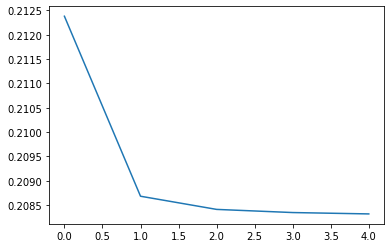

In [27]:
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

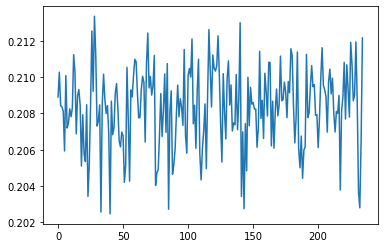

In [28]:
plt.plot(batch_loss.cpu().detach());

In [29]:
imgs, _ = next(iter(train_dataloader))

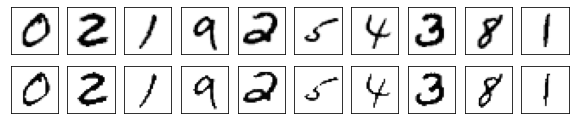

In [30]:
num_images=10
with torch.no_grad():
  reconstructed=autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(2,num_images,sharey=True)
  fig.set_figheight(2)
  fig.set_figwidth(10)
  rand_idx=torch.randint(size=(num_images,),high=imgs.size(0))
  for idx in range(num_images):
    axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(),cmap='Greys')
    axes[0,idx].axes.get_xaxis().set_visible(False)
    axes[0,idx].axes.get_yaxis().set_visible(False)


    axes[1,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(),cmap='Greys')
    axes[1,idx].axes.get_xaxis().set_visible(False)
    axes[1,idx].axes.get_yaxis().set_visible(False)


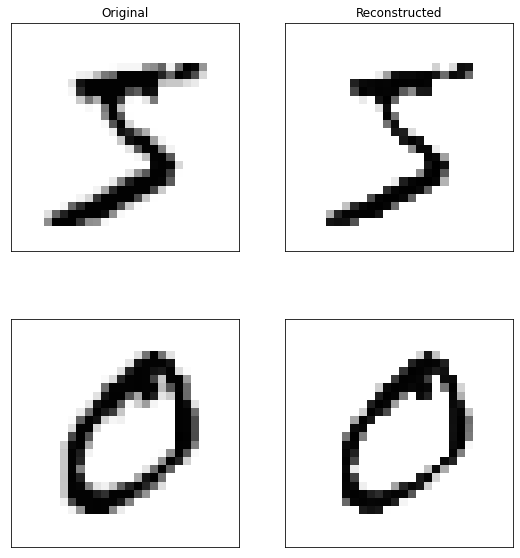

In [31]:
num_images=2
with torch.no_grad():
  reconstructed=autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(num_images,2)
  fig.set_figheight(10)
  fig.set_figwidth(9)
  for idx in range(num_images):
    axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(),cmap='Greys')
    axes[idx,0].axes.get_xaxis().set_visible(False)
    axes[idx,0].axes.get_yaxis().set_visible(False)
    

    axes[idx,1].imshow(reconstructed[idx,...].reshape(28,28).detach(),cmap='Greys')
    axes[idx,1].axes.get_xaxis().set_visible(False)
    axes[idx,1].axes.get_yaxis().set_visible(False)
axes[0,0].set_title("Original");
axes[0,1].set_title("Reconstructed");

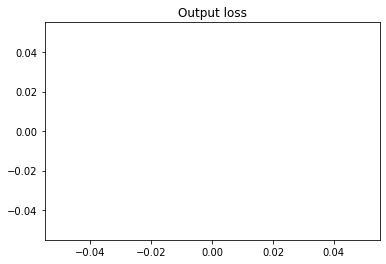

In [32]:
plt.title("Output loss")
plt.plot(output_loss);